## 벽돌깨기 - DQN
---
Deep-Q-Network 방식으로 인공지능이 플레이하는 벽돌깨기를 구현.

"Human level control through deep reinforcement learning" - V Mnih, et al. 2015 

[논문 링크](https://web.stanford.edu/class/psych209/Readings/MnihEtAlHassibis15NatureControlDeepRL.pdf)

In [1]:
# 필요 패키지를 호출
import sys
sys.path.append('../')
import numpy as np
import copy
import pandas as pd
import time

import torch
import torch.nn as nn
import torch.optim as optim


# material - atari_util에 필요한 모듈을 호출
from material.atari_util import *
from Replay_buffer import ReplayBuffer

import gym
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import clear_output
from tqdm import trange

In [2]:
torch.__version__

'1.8.1'

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

A.L.E: Arcade Learning Environment (version 0.7.5+db37282)
[Powered by Stella]


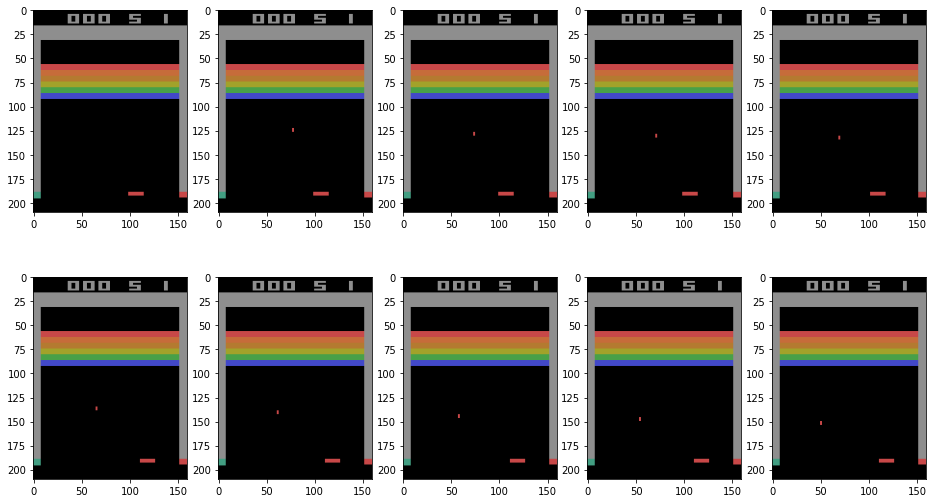

In [4]:
# 환경 분석 - 게임 화면부터 살펴봅시다
env = gym.make("Breakout-v4")
env.reset()

fig = plt.figure(figsize=(16,9))

# 임의의 10번의 행동을 수행하면서 환경을 렌더링
for row in range(5):
    for col in range(2):
        ax = fig.add_subplot(2,5,row*2+col+1)
        ax.imshow(env.render('rgb_array'))
        env.step(env.action_space.sample())
plt.show()

In [5]:
# 이미지 크기
img = np.array(env.render('rgb_array'))#.shape
print(img.shape)

(210, 160, 3)


### Step 1. 게임 화면 전처리
---
개요

1. 실제 아타리 게임화면 이미지(채널,가로,세로) $\rightarrow$ (3,210,160)

2. 실제 이미지는 불필요한 정보를 담고 있음 $\rightarrow$ 이미지 Crop & resizing

---

방법 

1. 불필요한 이미지 Crop (점수판)

2. 이미지 사이즈 조절 (3,21,160) $\rightarrow$ (1,64,64): 컬러에서 회색조, 가로 세로 64x64

In [6]:
from gym.core import ObservationWrapper
from gym.spaces import Box

class PreprocessAtariObs(ObservationWrapper):
    def __init__(self, env):
        """A gym wrapper that crops, scales image into the desired shapes and grayscales it."""
        ObservationWrapper.__init__(self, env)

        self.img_size = (1, 64, 64)
        self.observation_space = Box(0.0, 1.0, self.img_size,dtype=np.float32)

    def _to_gray_scale(self, rgb, channel_weights=[0.8, 0.1, 0.1]):
        dummy = 0
        for idx,channel_weight in enumerate(channel_weights):
            dummy += channel_weight*(rgb[:,:,idx])
        return np.expand_dims(dummy,axis=-1)
    
    def observation(self, img):      
        # Crop -> 점수판 없애기
        img = img[25:,:]
        img = Image.fromarray(np.uint8(img),'RGB')
        img = img.resize((64,64))
        img = np.array(img)
        img = self._to_gray_scale(img)/255.
        return np.array(img,dtype=np.float32).transpose((2,0,1))

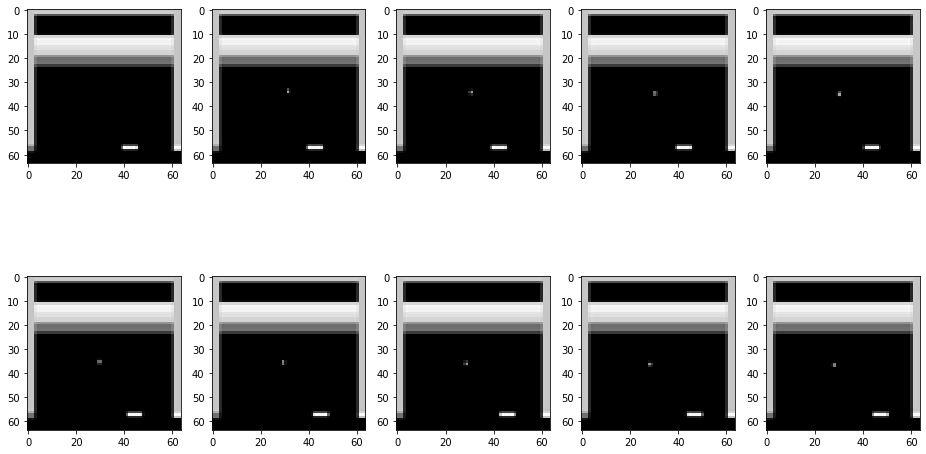

In [7]:
env = gym.make("BreakoutNoFrameskip-v4") 
env = PreprocessAtariObs(env)
observation_shape = env.observation_space.shape
n_actions = env.action_space.n
env.reset()
obs, _, _, _ = env.step(env.action_space.sample())

n_cols = 5
n_rows = 2
fig = plt.figure(figsize=(16, 9))
obs = env.reset()
for row in range(n_rows):
    for col in range(n_cols):
        ax = fig.add_subplot(n_rows, n_cols, row * n_cols + col + 1)
        ax.imshow(obs[0, :, :], interpolation='none', cmap='gray')
        obs, _, _, _ = env.step(env.action_space.sample())
plt.show()

# Wrapping
---
개요

1. 실제 게임처럼 환경을 조작 - 5개의 Life 안에 최고의 점수를 내기

2. 행동:[정지, 발사, 좌, 우] - 새로운 Life에서 자동으로 공을 발사 하도록 조작

OpenAI baseline에서 발췌

In [8]:
from material.atari_wrapper import *

def PrimaryAtariWrap(env,clip_rewards=True):
    env = MaxAndSkipEnv(env, skip=4) # 설명 : 지나치게 빠른 프레임 -> 4 프레임씩 자르기
    #env = EpisodicLifeEnv(env)       # 설명 : 1 에피소드를 초기 라이프 -> 소진 으로 세팅
    env = EpisodicLifeEnv2(env)       # 설명 라이프 모두 소진시 에피소드 종료
    env = FireResetEnv(env)          # 설명 : 라이프 소진시 자동으로 새 게임 시작(발사)
    if clip_rewards:                 # 설명: 보상에 대한 clipping, 처벌: -1, 보상: +1 로 reward 범위 제한
        env = ClipRewardEnv(env)
    env = PreprocessAtariObs(env)    # 이미지 전처리
    return env

## Frame_buffer 
---
연속 4프레임의 state를 하나로 묶습니다. RGB색의 개념대신 4step의 시간을 채널로 고려

In [9]:
class FrameBuffer(Wrapper):
    def __init__(self, env, n_frames=4):
        """A gym wrapper that reshapes, crops and scales image into the desired shapes"""
        super(FrameBuffer, self).__init__(env)     
        n_channels, height, width = env.observation_space.shape
        obs_shape = [n_channels * n_frames, height, width]
        self.observation_space = Box(0.0, 1.0, obs_shape, dtype=np.float32)
        self.framebuffer = np.zeros(obs_shape)

    def reset(self):
        """resets breakout, returns initial frames"""
        self.framebuffer = np.zeros_like(self.framebuffer)
        self.update_buffer(self.env.reset())
        return self.framebuffer

    def step(self, action):
        """plays breakout for 1 step, returns frame buffer"""
        new_img, reward, done, info = self.env.step(action)
        self.update_buffer(new_img)
        return self.framebuffer, reward, done, info

    def update_buffer(self, img):
        offset = self.env.observation_space.shape[0]
        cropped_framebuffer = self.framebuffer[:-offset]
        self.framebuffer = np.concatenate(
            [img, cropped_framebuffer], axis=0)

In [10]:
def make_env(clip_rewards=True, seed=None):
    env = gym.make("BreakoutNoFrameskip-v4") 
    if seed is not None:
        env.seed(seed)
    env = PrimaryAtariWrap(env, clip_rewards)
    env = FrameBuffer(env, n_frames=4)
    return env

In [11]:
env = make_env(True,123)
env.reset()
n_actions = env.action_space.n
state_shape = env.observation_space.shape

(4, 64, 64)
(4, 64, 64)


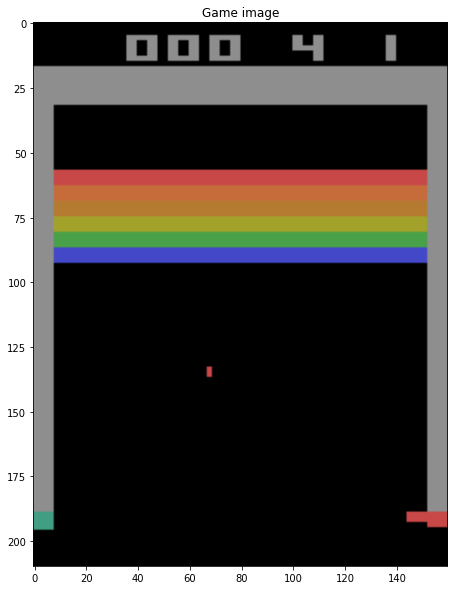

(4, 64, 64)


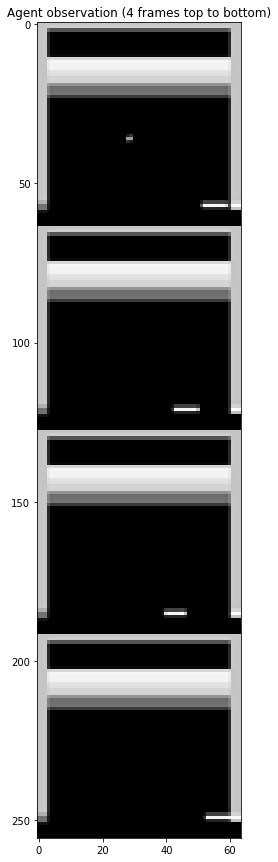

(4, 64, 64)
(256, 64)


In [12]:
def img_by_obs(obs, state_dim):
    """
    Unwraps obs by channels.
    observation is of shape [c, h=w, w=h]
    """
    print(obs.shape)
    return obs.reshape([-1, state_dim[2]])

for _ in range(12):
    obs, _, _, _ = env.step(env.action_space.sample())

print(obs.shape)
print(state_shape)
plt.figure(figsize=[12,10])
plt.title("Game image")
plt.imshow(env.render("rgb_array"))
plt.show()

plt.figure(figsize=[15,15])
plt.title("Agent observation (4 frames top to bottom)")
plt.imshow(img_by_obs(obs, state_shape), cmap='gray')
plt.show()
dummy = img_by_obs(obs,state_shape)
print(dummy.shape)

# Epsilon-decay 함수 - 선형감쇠

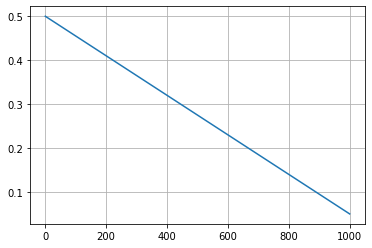

In [13]:
def linear_decay(init,finish,step,total_step):
    if step >= total_step:
        return finish
    else:
        return (finish - init) / total_step * (step - total_step) + finish
    
total_step = 1000
steps = np.linspace(0,1000)
init = 0.5
finish = 0.05

eps = []
for step in steps:
    eps.append(linear_decay(init,finish,step,total_step))

plt.plot(steps,eps)
plt.grid()

# Replay buffer 호출

In [14]:
replay_buffer = ReplayBuffer(5*10**4)

# 1000번의 랜덤 샘플 경험 입력
state = env.reset()
for i in range(1000):
    action = env.action_space.sample()
    next_state,reward,done,_ = env.step(action)
    replay_buffer.add(state,action,reward,next_state,done)
    if done:
        state = env.reset()
    state = next_state

In [15]:
class DQN_Atari(nn.Module):
    def __init__(self,n_actions,epsilon=0.05):
        super(DQN_Atari,self).__init__()        
        self.epsilon = epsilon
        self.n_actions = n_actions

        
        # 모델 구조 정의
        self.seq = nn.Sequential(
            nn.Conv2d(4,16,3,stride=2),
            nn.ReLU(),
            nn.Conv2d(16,32,3,stride=2),
            nn.ReLU(),
            nn.Conv2d(32,64,3,stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136,256),
            nn.ReLU(),
            nn.Linear(256,self.n_actions)
        )
        
    def forward(self,state):
        '''
        신경망 순전파, Q-함수 계산
        입력:
            state,  [batch, 4, 64, 64]
        출력:
            Q(s,a), [batch, n_actions]
        '''
        Q_function = self.seq(state)
        return Q_function
    
    def get_actions(self, qvalues):
        '''
        [batch,action] 형태의 Q함수, epsilon값을 기준으로 Exploration vs Exploitation
        입력: 
            Q-함수, [batch, action]
        출력:
            최적행동, [batch]
        '''
        epsilon = self.epsilon
        qvalues = qvalues.detach().cpu().numpy()
        batch_size, n_actions = qvalues.shape
        
        should_explore = np.random.choice([0, 1], batch_size, p=[1-epsilon, epsilon])
        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)
        return np.where(should_explore, random_actions, best_actions)    

# Hyper parameter 정의

In [16]:
seed = 123
sample_games = 5

init_eps = 0.5
fin_eps = 0.05

replay_buffer_size=2*10**4
batch_size=32
epsilon_start = 1
learning_rate = 1e-04
gamma = 0.99

loss_log_period = 100
model_update_period = 5000

max_episode= 10000000 # 적절한 학습 성능을 보이면 종료
total_steps = 5*1e+05

max_grad_norm=10

In [17]:
env = make_env(True,seed)
env.reset()
n_actions = env.action_space.n
state_shape = env.observation_space.shape

In [18]:
# A 신경망, B 신경망 생성
train_agent = DQN_Atari(n_actions,epsilon_start).to(device)
target_agent = DQN_Atari(n_actions,epsilon_start).to(device)
optimizer = optim.Adam(train_agent.parameters(),lr=learning_rate)

target_agent.load_state_dict(train_agent.state_dict())

<All keys matched successfully>

# DQN 손실함수 정의

In [19]:
def TD_loss(batch_sample,train_agent,target_agent,env,gamma=0.99):
    '''
    TD loss함수 계산코드
    입력: 
        batch_sample - 리플레이로부터 받은 샘플(S,A,R,S',done)
        train_agent - 훈련에이전트
        target_agent - 타겟에이전트
        env - 환경
        gamma - 할인율
    출력
        loss - TD-error RMS
        sum((R+gamma*max_a(Q(s,a))-Q(s,a))**2)/n
    '''
    states,actions,rewards,next_states,dones = batch_sample

    states = torch.FloatTensor(states).to(device)
    actions = torch.LongTensor(actions).to(device)
    rewards = torch.FloatTensor(rewards).to(device)
    next_states = torch.FloatTensor(next_states).to(device)
    dones = torch.ByteTensor(dones).to(device)
    not_dones = 1-dones
    
    train_Q = train_agent(states)
    target_Q = target_agent(next_states)
    train_Q = train_Q[range(len(actions)), actions]
    
    TD_target = rewards+not_dones*gamma*torch.max(target_Q,dim=-1).values
    loss = torch.mean((TD_target.detach()-train_Q)**2)
    return loss

# 평가함수 정의
---
1. 환경 random_seed 고정

2. Exploitation

In [20]:
def evaluate_reward_loss(agent,n_games=1,seed=123):
    env = make_env(clip_rewards=False,seed=seed)
    rewards, losses = [], []
    for ng in range(n_games):
        state = env.reset()
        reward = 0
        while True:            
            torch_state = torch.FloatTensor(state).to(device)
            qvalues = agent(torch.unsqueeze(torch_state,0)).detach().cpu().numpy()
            action = qvalues.argmax(axis=-1)[0]
            state,r,done,inf = env.step(action)
            reward += r
            if done:
                #print(ng,done,inf)
                break
        rewards.append(reward)
    return np.mean(rewards)

10800번째 에피소드 결과
Epsilon: 0.05
메모리 버퍼 크기: 50000
최근 에피소드 보상 = 32.0
최근 에피소드 TD오차 = 0.03097592107951641


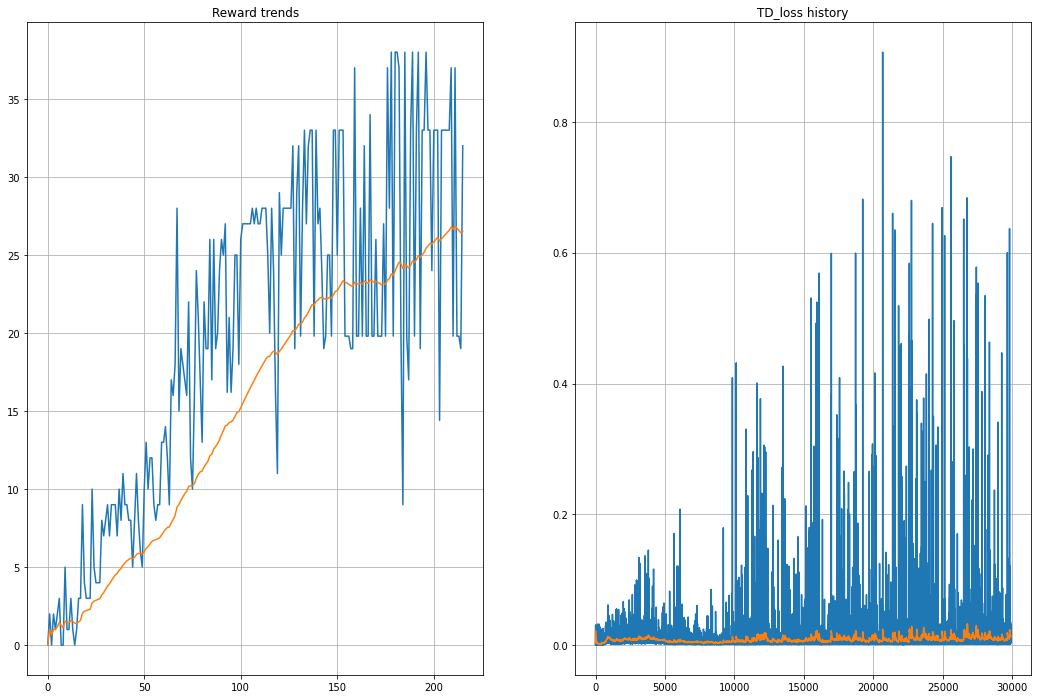

  0%|                                                      | 10823/10000000 [11:47:06<11610:01:08,  4.18s/it]

In [ ]:
def moving_average(x, span=100):
    return pd.DataFrame({'x': np.asarray(x)}).x.ewm(span=span).mean().values

reward_record, TDloss_record, clipped_loss_record = [], [], []
cnt = 0
rewards = 0
env = make_env(True,seed)

for ep in trange(max_episode): 
    done = False
    state = env.reset()
    
    total_reward = 0
    while True:
        torch_state = torch.FloatTensor(state).to(device)
        qvalues = train_agent(torch.unsqueeze(torch_state,0))
        action = train_agent.get_actions(qvalues)

        next_state,reward,done,_ = env.step(action[0])
        replay_buffer.add(state,action[0],reward,next_state,done)
        
        batch_sample = replay_buffer.sample(batch_size)
        loss = TD_loss(batch_sample,train_agent,target_agent,env,gamma=gamma)
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(train_agent.parameters(),max_grad_norm)
        optimizer.step()
        
        total_reward += reward
        
        if cnt % model_update_period == 0:
            target_agent.load_state_dict(train_agent.state_dict())
            
        if cnt % loss_log_period == 0:
            TDloss_record.append(loss.item())
            #clipped_loss_record.append(grad_norm.item())
            
        if done:
            break
        
        # 업데이트
        state = next_state
        train_agent.epsilon = linear_decay(init_eps,fin_eps,cnt,total_steps)
        cnt += 1
    
    if ep % 50 == 0 and ep != 0:
    #if ep % 50 == 0:
        rewards = evaluate_reward_loss(train_agent,n_games=sample_games,seed=seed)
        reward_record.append(rewards)

        clear_output(True)
        print(f'{ep}번째 에피소드 결과')
        print(f'Epsilon: {train_agent.epsilon}')
        print(f'메모리 버퍼 크기: {len(replay_buffer)}')
        print(f'최근 에피소드 보상 = {reward_record[-1]}')
        print(f'최근 에피소드 TD오차 = {TDloss_record[-1]}')
        
        plt.figure(figsize=[18, 12])
        
        plt.subplot(1,2,1)
        plt.title("Reward trends")
        plt.plot(reward_record)
        plt.plot(moving_average(reward_record))
        plt.grid()
        
        plt.subplot(1,2,2)
        plt.title("TD_loss history")
        plt.plot(TDloss_record)
        plt.plot(moving_average(TDloss_record))
        plt.grid()
        
        plt.show()
    
    # 학습 종료
    if rewards >= 200:
        best_agent = copy.deepcopy(train_agent)
        print(f"평가용 5 게임 평균 보상: {rewards}")
        print(f"학습종료")
        break

In [ ]:
torch.save(best_agent,'./ckpt/atari_breakout/DQN_Atari_best_agent.pth')
#train_agent = torch.load('./Atari_DQN_agent.pth')
#best_agent = copy.deepcopy(train_agent)

In [ ]:
import gym.wrappers

def record(state,agent,env,vid):
    reward = 0

    while True:
        vid.capture_frame()
        torch_state = torch.FloatTensor(state).to(device)
        qvalues = agent(torch.unsqueeze(torch_state,0)).detach().cpu().numpy()
        action = qvalues.argmax(axis=-1)[0]
        state,r,done,_ = env.step(action)
        reward += r
        
        if done:
            break
    vid.close()
    return reward

env = make_env(clip_rewards=False,seed=seed)
vid = gym.wrappers.monitoring.video_recorder.VideoRecorder(env,path='./videos/atari_breakout/Your_agent.mp4',enabled=True)
vid.render_mode="rgb_array"
state = env.reset()
#rewards = record(state,best_agent,env,vid)

In [ ]:
from IPython.display import Video

#Video('./videos/atari_breakout/Your_agent.mp4',embed=True,width=512, height=512)
Video('./videos/atari_breakout/Best_agent_vol2.mp4',embed=True,width=512, height=512)